I. 데이터 설명

불량 판별을 위한 아크용접 이미지에서 "Good"과 "Bad"를 판별하는 이진 분류 과제입니다.



1. 데이터 특성
이미지 개수 : Train 3500개 , Test : 1500개  
이미지 크기 : 600x600  
이미지 클래스 : 2개 (0: good, 1: bad)

In [1]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
#필요한 라이브러리 import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#working directory 옮기기
%cd /content/drive/MyDrive/Colab Notebooks/USG_AI
!ls
# !unzip -q -o "{MAIN_DIR}/task1.zip" #현재 디렉토리에 압축풀기

/content/drive/MyDrive/Colab Notebooks/USG_AI
task1  task2_done_0932.csv  task2_done_0939.csv
task2  task2_done_0936.csv  task2_done_{current_time}.csv


In [ ]:
MAIN_DIR = os.getcwd() #USG_AI까지의 경로
TASK1_DATA_DIR = MAIN_DIR + "/task1" #USG_AI/task1의 경로
TRAIN_DIR = TASK1_DATA_DIR + "/train" #task1/train
TEST_DIR = TASK1_DATA_DIR + "/test" #task1/test

In [ ]:
len(os.listdir(TRAIN_DIR)), len(os.listdir(TEST_DIR)) #압축해제된 파일 개수가 맞는지 확인

(3500, 1501)

In [ ]:
#개요에 명시된 test 파일 개수와 압축해제한 파일의 개수가 달라 확인

sample = pd.read_csv( TASK1_DATA_DIR+"/answer_sample.csv" )
file_name = sample["file_name"]
dir_list = os.listdir(TEST_DIR)
set(dir_list) - set(file_name) #.DS_Store 파일

{'.DS_Store'}

In [ ]:
train_labels = pd.read_csv(TASK1_DATA_DIR + "/train_labels.csv")
train_file = pd.DataFrame({"file_name" : train_labels["file_name"],
                           "file_path" : [TRAIN_DIR + "/" + i for i in os.listdir(TRAIN_DIR)],
                           "labels" : train_labels["bad"]})
train_file # train data의 이름, 경로, 라벨을 묶어 하나의 dataFrame 만들기

,file_name,file_path,labels
0,train0000.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...,0
1,train0001.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...,0
2,train0002.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...,0
3,train0003.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...,1
4,train0004.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...,1
...,...,...,...
3495,train3495.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...,1
3496,train3496.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...,0
3497,train3497.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...,1
3498,train3498.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...,1


In [ ]:
test_file = pd.DataFrame({"file_name" : [i for i in os.listdir(TEST_DIR) if i != ".DS_Store" ],
                           "file_path" : [TEST_DIR + "/" + i for i in os.listdir(TEST_DIR) if i != ".DS_Store" ]})

test_file #test 파일이름, 경로 dataFrame


,file_name,file_path
0,test0505.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...
1,test0499.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...
2,test0506.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...
3,test0503.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...
4,test0501.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...
...,...,...
1495,test0487.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...
1496,test0497.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...
1497,test0507.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...
1498,test0496.jpeg,/content/drive/MyDrive/Colab Notebooks/USG_AI/...


In [ ]:
#데이터 셋 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        data_row = self.dataframe.iloc[idx]
        image_path = data_row["file_path"]
        image = Image.open(image_path).convert("RGB")
        label = data_row["labels"]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
#train_transform
#train_transform은 데이터 증강(data augmentation) 해야함

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#test_transform 만들어야 함
#Resize(224,224)
#ToTensor()만 하면 됨

# 데이터셋에 전처리 적용
BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataset = CustomDataset(dataframe=train_file, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS)

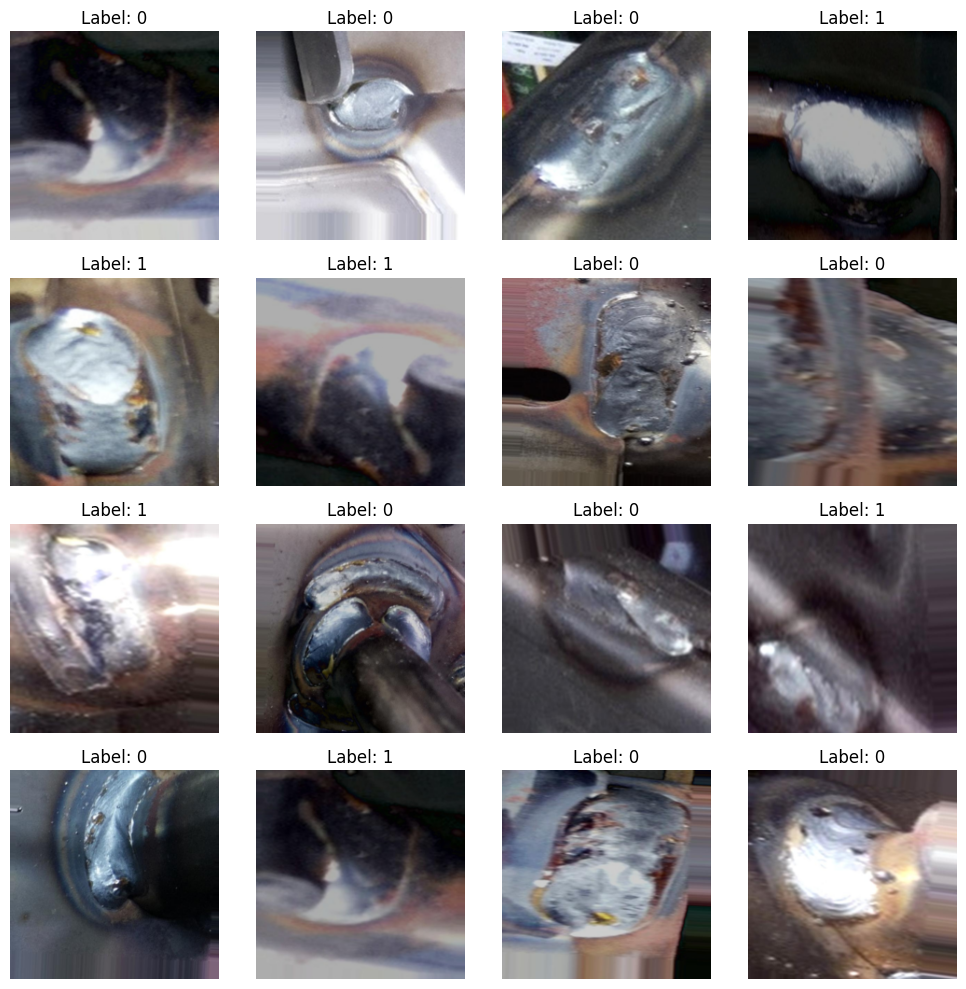

In [ ]:
def show_rgb_images(loader, num_images=16):
    # DataLoader에서 한 배치 가져오기
    images, labels = next(iter(loader))

    # 4x4 그리드에 이미지 시각화
    grid_size = int(num_images ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        image = images[i].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

        ax.imshow(image)
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')  # 축 제거

    plt.tight_layout()
    plt.show()

show_rgb_images(train_loader)


In [ ]:
#test_transform

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_file['labels'] = 0
test_dataset = CustomDataset(dataframe=test_file, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=1)

In [ ]:
import torchvision.models as models

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.2MB/s]


In [ ]:
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)


In [ ]:
criterion = nn.BCELoss()  # 이진교차
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images, labels.float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()  # 역전파
            optimizer.step()  # 가중치
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


In [ ]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 0.7549
Epoch [2/10], Loss: 0.6999
Epoch [3/10], Loss: 0.6995
Epoch [4/10], Loss: 0.7003
Epoch [5/10], Loss: 0.6951
Epoch [6/10], Loss: 0.6946
Epoch [7/10], Loss: 0.6926


In [ ]:
#test
from datetime import datetime

def predict(model, test_loader):
    model.eval()
    image_names = []
    predictions = []

    with torch.no_grad():
        for images, _ in test_loader:
            outputs = model(images)
            predicted = (outputs > 0.5).float().squeeze()

            batch_filenames = test_loader.dataset.dataframe.loc[
                test_loader.dataset.dataframe.index[:len(images)], 'file_name'
            ]
            image_names.extend(batch_filenames)
            predictions.extend(predicted.numpy().tolist())


    results_df = pd.DataFrame({
        'file_name': image_names,
        'bad': predictions
    })

    return results_df

In [ ]:
results_df = predict(model, test_loader)

In [ ]:
def save_results(results_df):
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f"task1_{current_time}.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")


save_results(results_df)

Results saved to task1_20241110_054152.csv
